# Goal

The goal here is to write everything with modular code and then conduct experiments that allow us to get ECN networks to work properly on the CityScapes dataset. We will try a few different approaches to improve results:

* Try different architectures, including a two-stage approach, as well as trying to predict residuals rather than the original $y$ labels
* Increasing the receptive field size on the input as well as the output


# Setup

In [13]:
import os
import matplotlib.pyplot as plt
import argparse
import numpy as np

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D, Flatten, Reshape, Add, Concatenate, MaxPool2D
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras import backend as K

from model.unet import unet, unet_small, dice_coef
from model.fcn import fcn_8s
from model.pspnet import pspnet50
from dataset_parser import generator_coarse, generator

from scripts import *

%load_ext autoreload
%autoreload 2

print('GPUs available:', K.tensorflow_backend._get_available_gpus())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GPUs available: ['/job:localhost/replica:0/task:0/device:GPU:0']


# Train a Model on Coarse Data

In [7]:
TRAIN_BATCH = int(4)
VAL_BATCH = int(4)
lr_init = 1e-4
lr_decay = 5e-4
vgg_path = None
model_name = "modular_unet_coarse_weights.h5"

labels = ['background', 'car', 'road']  # Use only 3 classes.
ignore_pedestrians=not('person' in labels)

coarse_model = unet(input_shape=(256, 512, 3), num_classes=len(labels),
                    lr_init=lr_init, lr_decay=lr_decay, vgg_weight_path=vgg_path)

In [8]:
checkpoint = ModelCheckpoint(filepath=model_name,
                             monitor='val_dice_coef',
                             save_best_only=True,
                             save_weights_only=True)

In [9]:
history = coarse_model.fit_generator(generator_coarse.data_generator('dataset_parser/data-coarse.h5', TRAIN_BATCH, 'train_extra', ignore_pedestrians=ignore_pedestrians),
                                     steps_per_epoch= 5000 // TRAIN_BATCH,
                                     validation_data=generator.data_generator('dataset_parser/data.h5', VAL_BATCH, 'val', ignore_pedestrians=ignore_pedestrians),
                                     validation_steps=500 // VAL_BATCH,
                                     callbacks=[checkpoint],
                                     epochs=5, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
500
5000


1250/1250 [==============================] - 415s 332ms/step - loss: 0.2378 - dice_coef: 0.8605 - val_loss: 0.3592 - val_dice_coef: 0.8212
Epoch 2/5
1250/1250 [==============================] - 397s 318ms/step - loss: 0.1525 - dice_coef: 0.9109 - val_loss: 0.2863 - val_dice_coef: 0.8615
Epoch 3/5
1250/1250 [==============================] - 398s 318ms/step - loss: 0.1297 - dice_coef: 0.9247 - val_loss: 0.3151 - val_dice_coef: 0.8677
Epoch 4/5
1250/1250 [==============================] - 398s 318ms/step - loss: 0.1156 - dice_coef: 0.9329 - val_loss: 0.2953 - val_dice_coef: 0.8770
Epoch 5/5
1250/1250 [==============================] - 398s 319ms/step - loss: 0.1076 - dice_coef: 0.9377 - val_loss: 0.3069 - val_dice_coef: 0.8790


# View Predictions

Manually view them to confirm that the predictions on the training set are similar to the training labels

In [8]:
coarse_model.load_weights("unet_coarse_model_weight.h5")
# view_paired_predictions_on_training_data(coarse_model, ignore_pedestrians=ignore_pedestrians)

Manually view them to confirm that the predictions on the validation dataset are qualitatively similar to "coarse" labels

500


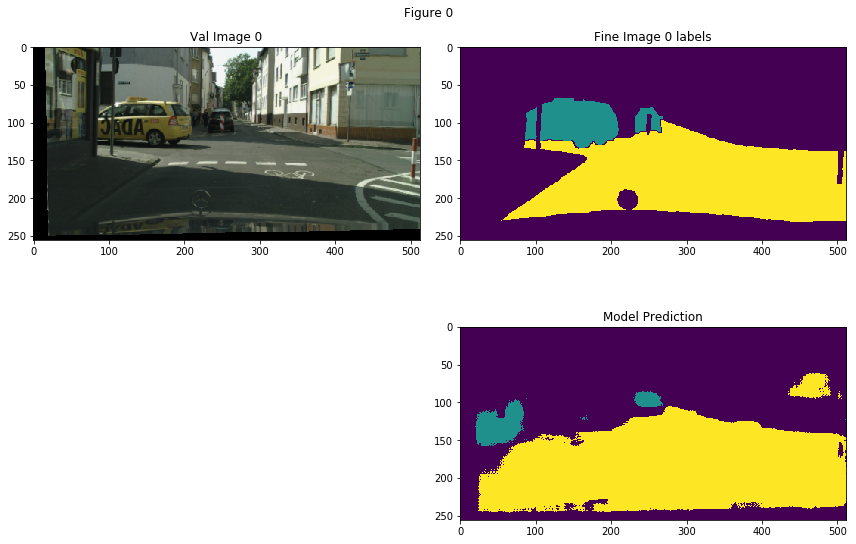

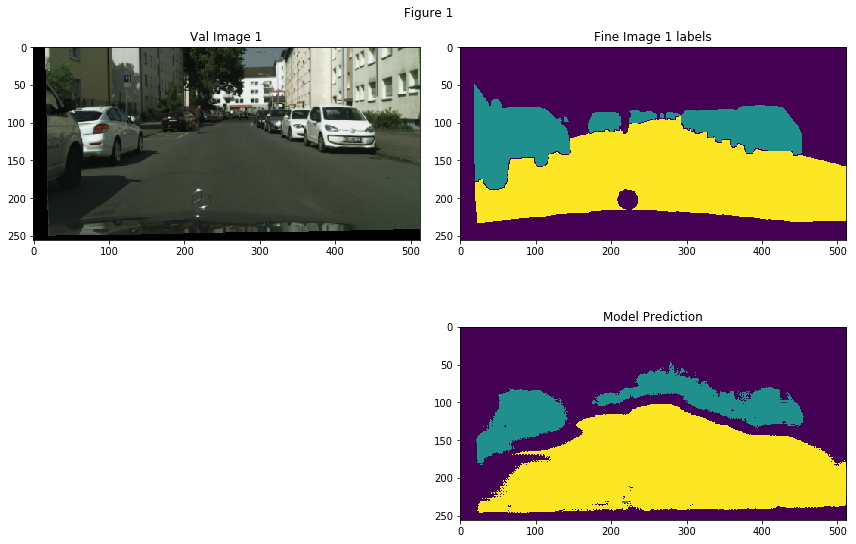

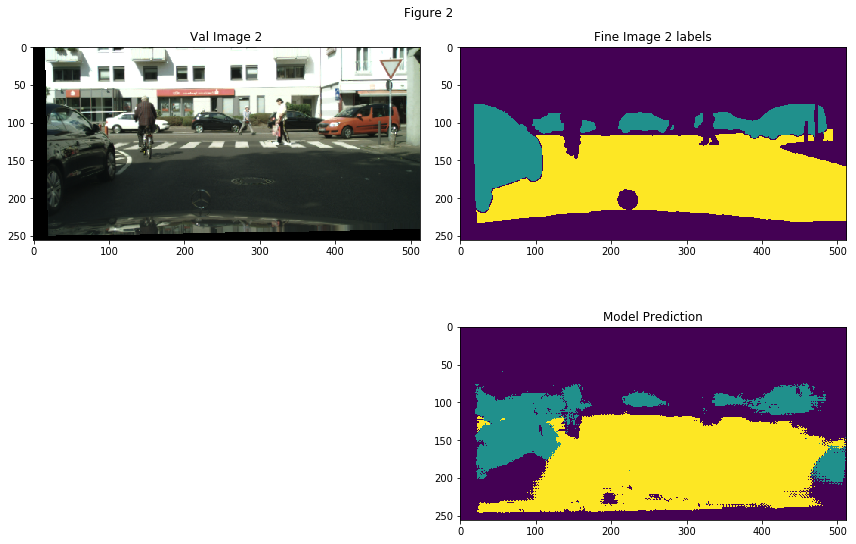

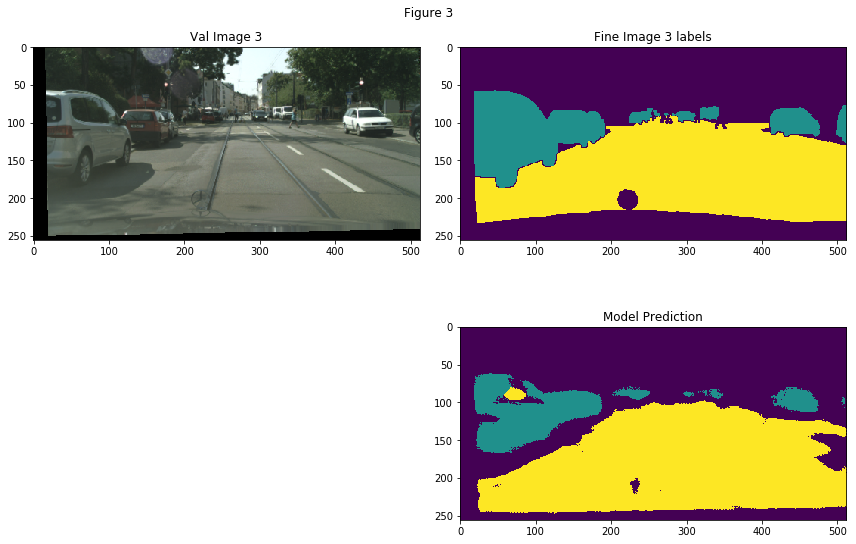

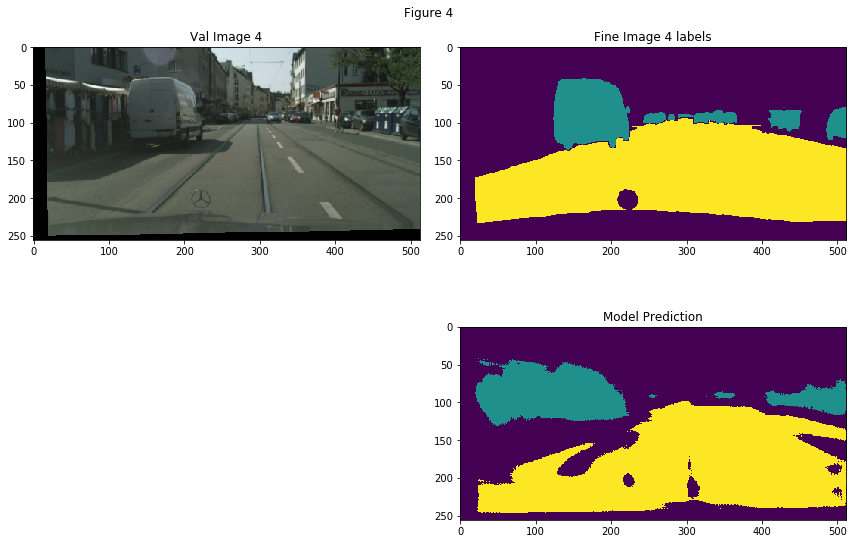

In [17]:
view_predictions_on_validation_data(coarse_model)

# Get Error-Correcting Model

In [22]:
input_window_size = 60
output_window_size = 6

ec_model = get_ec_model(input_window_size, output_window_size, dice_coef=dice_coef)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 60, 60, 3)    0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 60, 60, 3)    0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 60, 60, 6)    0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 60, 60, 8)    776         concatenate_7[0][0]              
__________

# Train EC Model 

In [104]:
n_epochs = 5
batch_size = 8
skip = 12

fine_generator = generator.data_generator('dataset_parser/data.h5', batch_size, 'train', ignore_pedestrians=ignore_pedestrians)
val_generator = generator.data_generator('dataset_parser/data.h5', batch_size, 'val', ignore_pedestrians=True)

x_val, y_val = next(val_generator)
y_val_coarse = coarse_model.predict(x_val)
x_val_batch, y_val_coarse_batch, y_val_diff_batch = get_ec_batch(
    x_val, y_val, y_val_coarse, input_window_size=input_window_size,
    output_window_size=output_window_size, skip=skip, diff=False)

for e in range(n_epochs):
    for i in range(500 // batch_size):
        x, y_fine = next(fine_generator)
        y_coarse = coarse_model.predict(x)
        x_batch, y_coarse_batch, y_diff_batch = get_ec_batch(x, y_fine, y_coarse, input_window_size=input_window_size,
                                                             output_window_size=output_window_size, skip=skip, diff=False)
        
        metrics = ec_model.train_on_batch([x_batch, y_coarse_batch], y_diff_batch)
#         print(metrics)
        print('=', end='')
    
    metrics = ec_model.evaluate([x_val_batch, y_val_coarse_batch], y_val_diff_batch)
    print('\nEpoch {}, batch {}, Validation metrics (loss, mse): {}'.format(e, i, metrics))

500
2975
5168/5168 [==============================] - 2s 367us/step

Epoch 0, batch 61, Validation metrics (loss, mse): [0.5762859116951379, 0.32131249533718215, 0.03793924365873123]
5168/5168 [==============================] - 1s 158us/step

Epoch 1, batch 61, Validation metrics (loss, mse): [0.571008136005778, 0.32059212098180695, 0.04136981582124905]
5168/5168 [==============================] - 1s 156us/step

Epoch 2, batch 61, Validation metrics (loss, mse): [0.5129355859046012, 0.320346461822374, 0.04170817939489618]
5168/5168 [==============================] - 1s 149us/step

Epoch 3, batch 61, Validation metrics (loss, mse): [0.5107661918059406, 0.3203367004084513, 0.042313087189529704]
5168/5168 [==============================] - 1s 155us/step

Epoch 4, batch 61, Validation metrics (loss, mse): [0.40420632682533086, 0.31979103769311223, 0.04228893980014804]


In [5]:
# ec_model.save_weights('ec-model-2-weights.h5')
ec_model.load_weights('ec-model-2-weights.h5')

# See Corrected Data

2975
2975


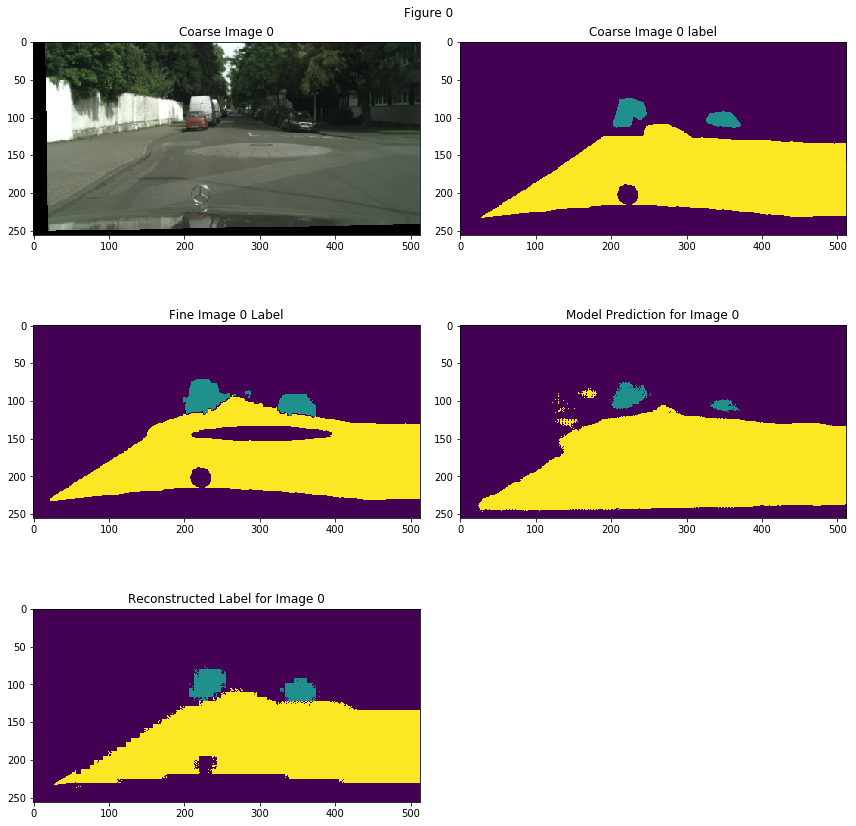

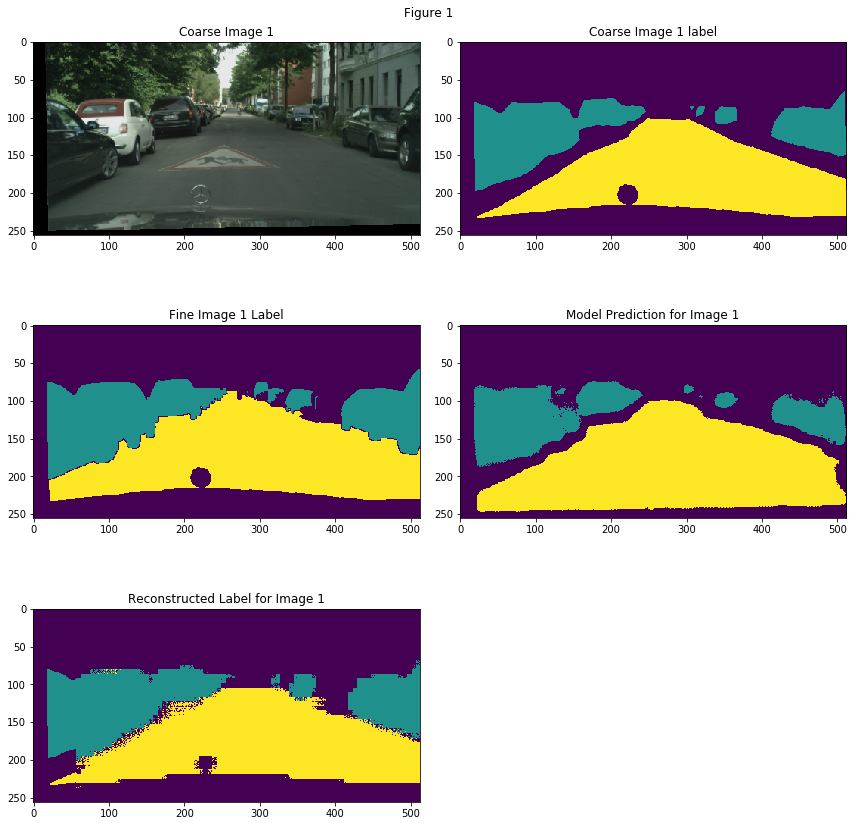

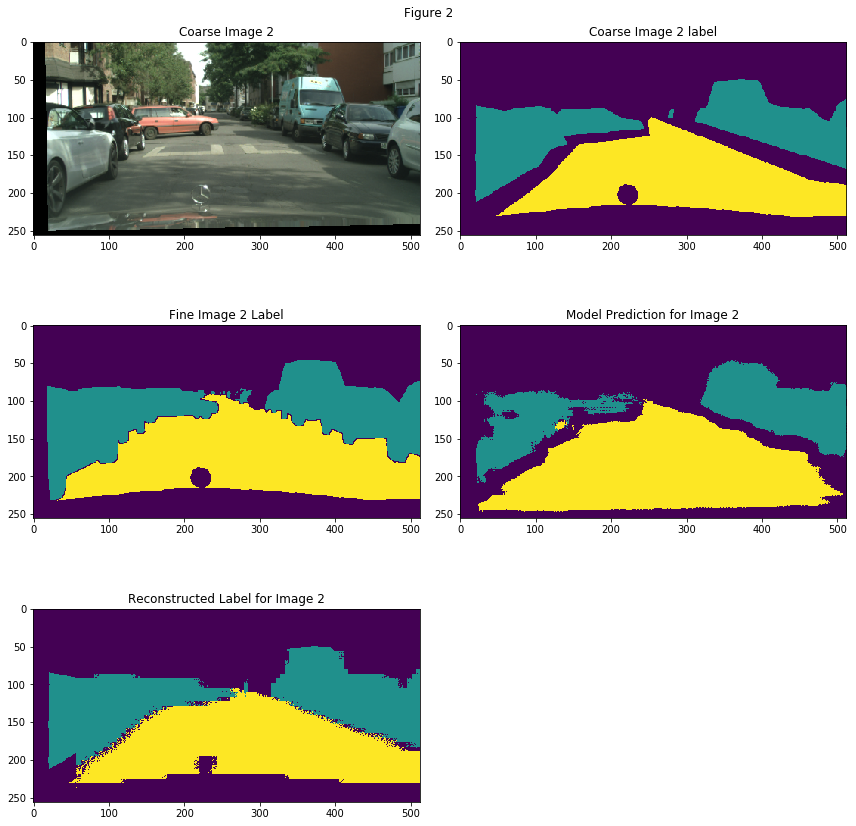

In [116]:
view_corrections_on_training_data(coarse_model, ec_model, n=3, ignore_pedestrians=ignore_pedestrians, skip=6, 
                                  diff=False, use_model_pred=False, output_window_size=output_window_size, 
                                  input_window_size=input_window_size)

# Retrain ECN but now with Dice Scores

In [25]:
n_epochs = 5
batch_size = 8
skip = 12
num_images = 500

fine_generator = generator.data_generator('dataset_parser/data.h5', batch_size, 'train', ignore_pedestrians=ignore_pedestrians)
val_generator = generator.data_generator('dataset_parser/data.h5', batch_size, 'val', ignore_pedestrians=True)

x_val, y_val = next(val_generator)
y_val_coarse = coarse_model.predict(x_val)
x_val_batch, y_val_coarse_batch, y_val_diff_batch = get_ec_batch(
    x_val, y_val, y_val_coarse, input_window_size=input_window_size,
    output_window_size=output_window_size, skip=skip, diff=False)

def evaluate_ecn_with_dice(ec_model):
    y_val_pred_batch = ec_model.predict([x_val_batch, y_val_coarse_batch])
    dice_score = compute_dice_on_ec_batches(y_val, y_val_pred_batch,
                                            input_window_size=input_window_size, output_window_size=output_window_size, 
                                            skip=skip, diff=False) 
    return dice_score

for e in range(n_epochs):
    for i in range(num_images // batch_size):
        x, y_fine = next(fine_generator)
        y_coarse = coarse_model.predict(x)
        x_batch, y_coarse_batch, y_diff_batch = get_ec_batch(x, y_fine, y_coarse, input_window_size=input_window_size,
                                                             output_window_size=output_window_size, skip=skip, diff=False)
        
        metrics = ec_model.train_on_batch([x_batch, y_coarse_batch], y_diff_batch)
        print('=', end='')
    
    metrics = evaluate_ecn_with_dice(ec_model)
    print('\nEpoch {}, batch {}, Validation metrics (dice): {}'.format(e, i, metrics))

500
2975
Epoch 0, batch 61, Validation metrics (dice): 0.9042288185487699
Epoch 1, batch 61, Validation metrics (dice): 0.9044547472335772
Epoch 2, batch 61, Validation metrics (dice): 0.9044042558642871
Epoch 3, batch 61, Validation metrics (dice): 0.9044331948684582
Epoch 4, batch 61, Validation metrics (dice): 0.9043388091104065


# Doing Training with Fixed Diff

In [34]:
input_window_size = 60
output_window_size = 6

ec_diff_model = get_ec_model(input_window_size, output_window_size, dice_coef=dice_coef)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 60, 60, 3)    0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 60, 60, 3)    0                                            
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 60, 60, 6)    0           input_12[0][0]                   
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 60, 60, 8)    776         concatenate_10[0][0]             
__________

In [49]:
from IPython.display import clear_output

n_epochs = 5
batch_size = 8
skip = 12
diff = True

fine_generator = generator.data_generator('dataset_parser/data.h5', batch_size, 'train', ignore_pedestrians=ignore_pedestrians)
val_generator = generator.data_generator('dataset_parser/data.h5', batch_size, 'val', ignore_pedestrians=ignore_pedestrians)

x_val, y_val = next(val_generator)
y_val_coarse = coarse_model.predict(x_val)
x_val_batch, y_val_coarse_batch, y_val_diff_batch = get_ec_batch(
    x_val, y_val, y_val_coarse, input_window_size=input_window_size,
    output_window_size=output_window_size, skip=skip, diff=diff)

def evaluate_ecn_with_dice(ec_model):
    y_val_pred_batch = ec_model.predict([x_val_batch, y_val_coarse_batch])
    dice_score = compute_dice_on_ec_batches(y_val, y_val_pred_batch,
                                            input_window_size=input_window_size, output_window_size=output_window_size, 
                                            skip=skip, diff=diff) 
    return dice_score


for e in range(n_epochs):
    for i in range(500 // batch_size):
        x, y_fine = next(fine_generator)
        y_coarse = coarse_model.predict(x)
        x_batch, y_coarse_batch, y_diff_batch = get_ec_batch(x, y_fine, y_coarse, input_window_size=input_window_size,
                                                             output_window_size=output_window_size, skip=skip, diff=diff)
        
        metrics = ec_diff_model.train_on_batch([x_batch, y_coarse_batch], y_diff_batch)
        print(metrics)
    
    metrics = evaluate_ecn_with_dice(ec_diff_model)
    print('\nEpoch {}, batch {}, Validation metrics (dice): {}'.format(e, i, metrics))
    
#     print('\nEpoch {}, batch {}, Validation metrics (loss, mse, dice): {}'.format(e, i, metrics))

500
2975
[2.7463372, 0.26213387, 0.019452222]
[2.3778589, 0.26061785, 0.018660188]
[2.0289745, 0.25932327, 0.018644616]
[1.9120939, 0.25759497, 0.018288642]
[1.7939986, 0.25738108, 0.01829036]
[1.7368642, 0.2589185, 0.018219307]
[1.6858311, 0.26300636, 0.018177308]
[1.6629946, 0.2611945, 0.018168775]
[1.6514167, 0.26137587, 0.018187476]
[1.6479067, 0.26101264, 0.018204166]
[1.6487192, 0.2616353, 0.018188301]
[1.6482944, 0.2581261, 0.018193357]
[1.6489978, 0.2588374, 0.018184725]
[1.6493763, 0.25839803, 0.018180074]
[1.648864, 0.25540477, 0.018186355]
[1.6488768, 0.25039092, 0.018186161]
[1.6487701, 0.25522664, 0.018187463]
[1.6495817, 0.25583842, 0.018177394]
[1.6493627, 0.25515106, 0.018180076]
[1.648866, 0.26245484, 0.01818613]
[1.6475316, 0.26185352, 0.018202428]
[1.6489916, 0.25636026, 0.018184438]
[1.6473004, 0.26778683, 0.018205225]
[1.6489441, 0.25963658, 0.018184828]
[1.6483958, 0.25514, 0.018191509]
[1.649344, 0.25792196, 0.018179785]
[1.6485939, 0.2515031, 0.018188901]
[1.649

KeyboardInterrupt: 

2975
2975


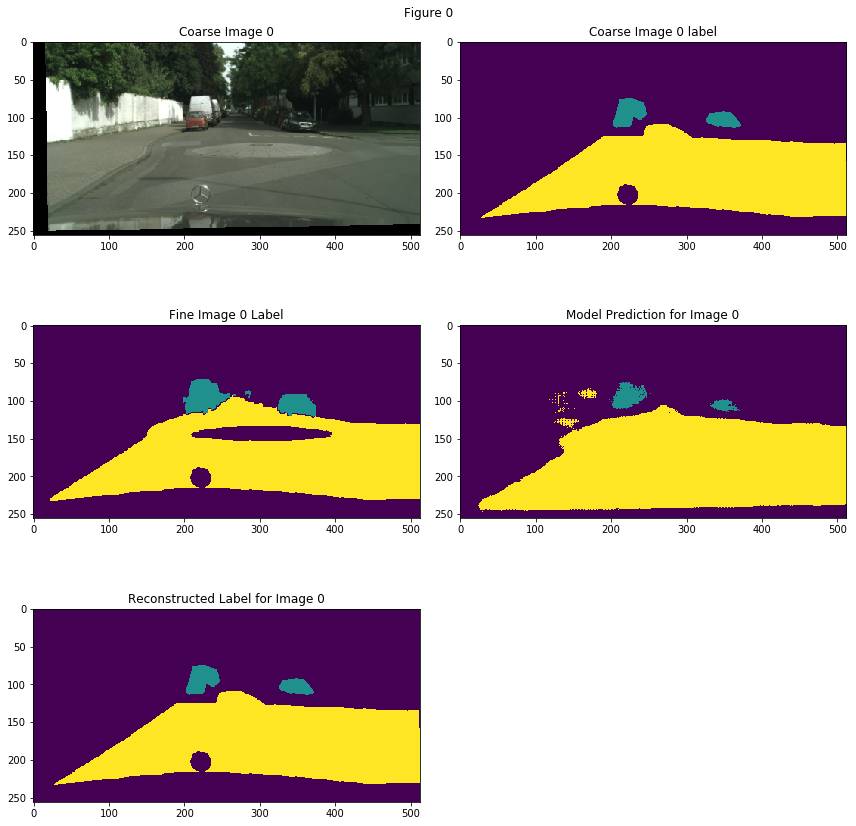

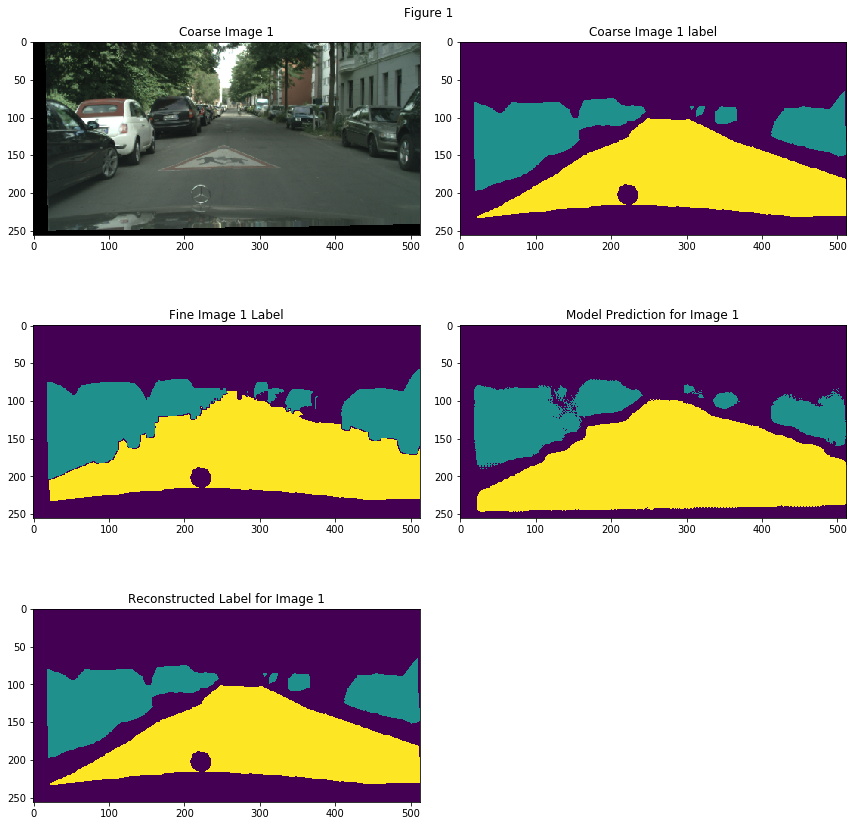

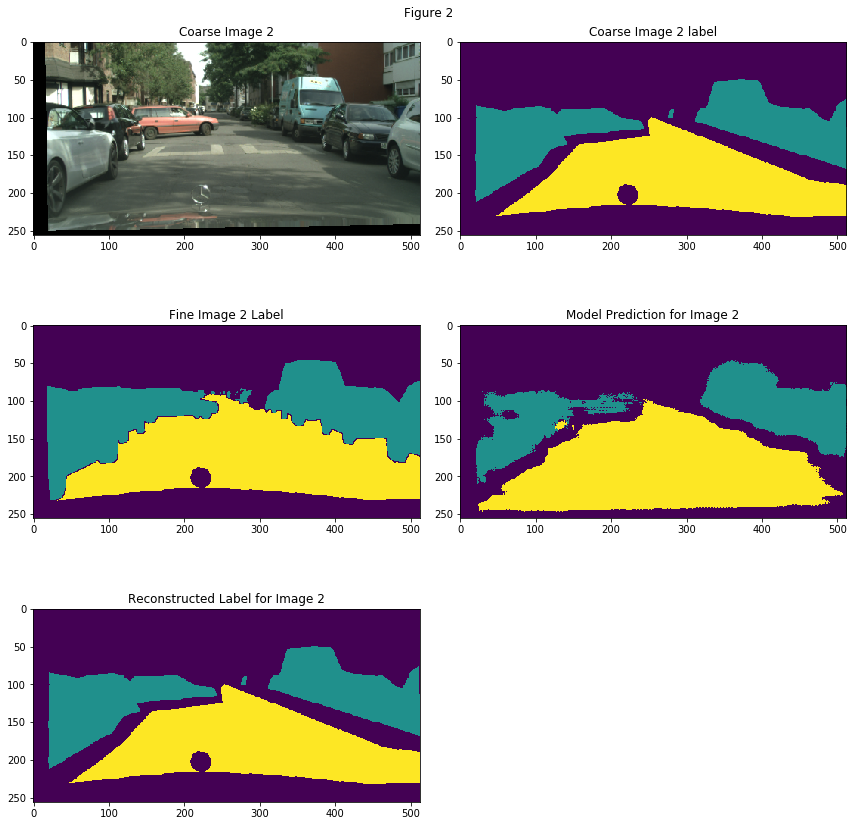

In [50]:
view_corrections_on_training_data(coarse_model, ec_diff_model, n=3, ignore_pedestrians=ignore_pedestrians, skip=6, 
                                  diff=True, use_model_pred=False, output_window_size=output_window_size, 
                                  input_window_size=input_window_size)